In [1]:
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import pandas as pd
import pickle
import matplotlib.path

import sys

sys.path.append('../')

from volume_preprocessing.preprocessing_utils import rotate_points, set_pia_zero

#### Topdown view

In [2]:
df_neuron = pd.read_pickle('../../../data/df_morphos.pkl')

In [3]:
RL_bounds = np.load('../volume_preprocessing/data/topdown_RL_bounds.npy')
AL_bounds = np.load('../volume_preprocessing/data/topdown_AL_bounds.npy')

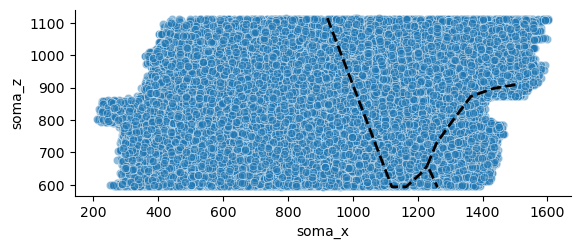

In [4]:
fig, ax = plt.subplots(1, 1)
sns.scatterplot(data=df_neuron, x='soma_x', y='soma_z', ax=ax, alpha=0.5)

ax.plot(
    RL_bounds[:, 0],
    RL_bounds[:, 1],
    '--',
    label='RL_bounds',
    color='black',
    linewidth=2,
)
ax.plot(
    AL_bounds[:, 0],
    AL_bounds[:, 1],
    '--',
    label='AL_bounds',
    color='black',
    linewidth=2,
)

ax.set_aspect('equal')
sns.despine()

#### Normalize pia to 0

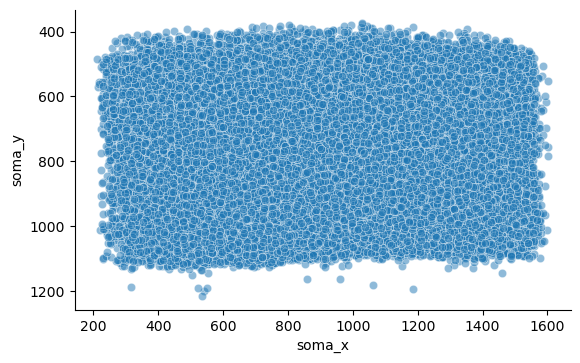

In [48]:
fig, ax = plt.subplots(1, 1)
sns.scatterplot(data=df_neuron, x='soma_x', y='soma_y', ax=ax, alpha=0.5)

ax.invert_yaxis()

ax.set_aspect('equal')
sns.despine()

In [8]:
pia_grid = np.load('../volume_preprocessing/data/pia_grid.npy')

In [53]:
df_neuron['soma_y'] = df_neuron['soma_y'] - (pia_grid[:, 1].mean() / 1000.0)

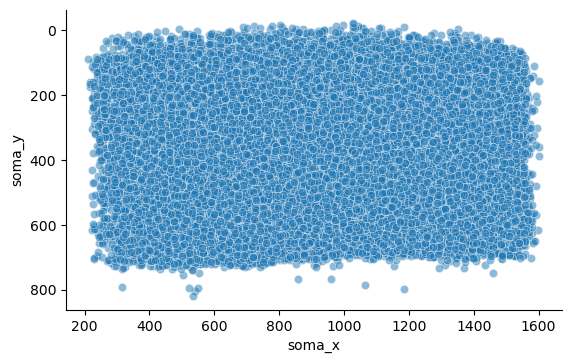

In [54]:
fig, ax = plt.subplots(1, 1)
sns.scatterplot(data=df_neuron, x='soma_x', y='soma_y', ax=ax, alpha=0.5)

ax.invert_yaxis()

ax.set_aspect('equal')
sns.despine()

#### Add soma coordinates rotated to make V1-HVA boundary orthogonal to x-axis

In [5]:
RL_bounds_align = np.load('../volume_preprocessing/data/topdown_RL_bounds_align.npy')
AL_bounds_align = np.load('../volume_preprocessing/data/topdown_AL_bounds_align.npy')

In [86]:
deg = 14

In [87]:
soma_centers = rotate_points(
    np.stack(df_neuron[['soma_x', 'soma_y', 'soma_z']].values), axis=1, degree=deg
)

In [88]:
df_neuron['soma_x_align'] = soma_centers[:, 0]
df_neuron['soma_y_align'] = soma_centers[:, 1]
df_neuron['soma_z_align'] = soma_centers[:, 2]

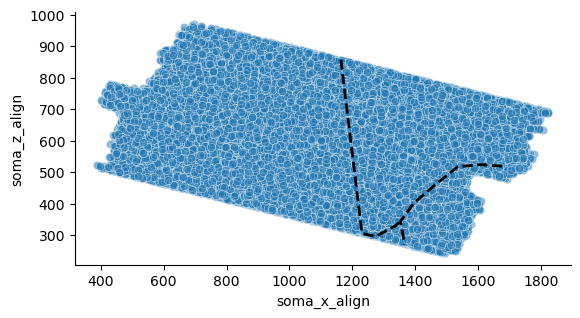

In [89]:
fig, ax = plt.subplots(1, 1)
sns.scatterplot(data=df_neuron, x='soma_x_align', y='soma_z_align', ax=ax, alpha=0.5)

ax.plot(*RL_bounds_align.T, '--', label='RL_bounds', color='black', linewidth=2)
ax.plot(*AL_bounds_align.T, '--', label='AL_bounds', color='black', linewidth=2)

ax.set_aspect('equal')
sns.despine()

#### Exclude boundary neurons

In [6]:
boundary = np.array(
    [
        [1.4e3, 0.62e3],
        [0.32e3, 0.62e3],
        [0.45e3, 1.08e3],
        [1.3e3, 1.08e3],
        [1.4e3, 0.9e3],
        [1.4e3, 0.9e3],
        [1.4e3, 0.62e3],
    ]
)

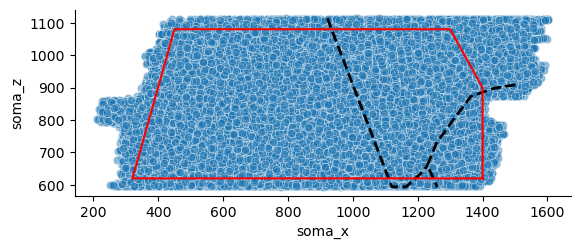

In [91]:
fig, ax = plt.subplots(1, 1)
sns.scatterplot(data=df_neuron, x='soma_x', y='soma_z', ax=ax, alpha=0.5)

ax.plot(
    RL_bounds[:, 0],
    RL_bounds[:, 1],
    '--',
    label='RL_bounds',
    color='black',
    linewidth=2,
)
ax.plot(
    AL_bounds[:, 0],
    AL_bounds[:, 1],
    '--',
    label='AL_bounds',
    color='black',
    linewidth=2,
)

plt.plot(boundary[:, 0], boundary[:, 1], color='red')

ax.set_aspect('equal')
sns.despine()

In [94]:
path = matplotlib.path.Path(boundary)
point_idcs = ~path.contains_points(np.stack(df_neuron[['soma_x', 'soma_z']].values))

In [99]:
np.unique(point_idcs, return_counts=True)

(array([False,  True]), array([43719, 26846]))

In [101]:
df_neuron['boundary'] = point_idcs

In [ ]:
df_neuron.loc[
    (df_neuron['boundary'] == True),
    'exclusion_criterion',
] = 'outside_boundary'
df_neuron.loc[(df_neuron['boundary'] == True), 'exclude'] = True

In [110]:
df_neuron = df_neuron.drop('boundary', axis=1)

In [111]:
df_neuron.value_counts('exclude')

exclude
False    43470
True     27095
dtype: int64

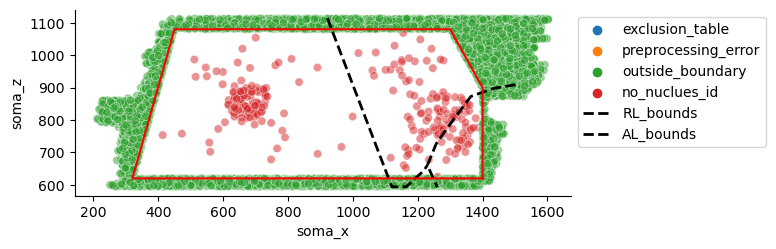

In [117]:
fig, ax = plt.subplots(1, 1)
sns.scatterplot(
    data=df_neuron, x='soma_x', y='soma_z', hue='exclusion_criterion', ax=ax, alpha=0.5
)

ax.plot(
    RL_bounds[:, 0],
    RL_bounds[:, 1],
    '--',
    label='RL_bounds',
    color='black',
    linewidth=2,
)
ax.plot(
    AL_bounds[:, 0],
    AL_bounds[:, 1],
    '--',
    label='AL_bounds',
    color='black',
    linewidth=2,
)

plt.plot(boundary[:, 0], boundary[:, 1], color='red')

ax.set_aspect('equal')
sns.despine()

plt.legend(bbox_to_anchor=[1, 1])

In [118]:
# df_neuron.to_pickle('data/df_morphos.pkl')